# Study Catalan Elections Results Dataset

Load libraries:

In [20]:
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
from unidecode import unidecode

pp = pprint.PrettyPrinter(indent=2)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

Load the dataset:

In [21]:
df = pd.read_pickle('../../data/raw/catalan-elections-results.pkl')
df_original = df.copy()

## Dataset Structure

Visualize the structure of the dataset:

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19751196 entries, 0 to 19751195
Data columns (total 21 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   index_autonumeric        Int64  
 1   id_eleccio               string 
 2   nom_eleccio              string 
 3   id_nivell_territorial    string 
 4   nom_nivell_territorial   string 
 5   territori_codi           string 
 6   territori_nom            string 
 7   secci_                   Int64  
 8   candidatura_codi         Int64  
 9   candidatura_denominacio  string 
 10  candidatura_sigles       string 
 11  vots                     Int64  
 12  escons                   Float64
 13  candidatura_color        string 
 14  candidatura_logotip      string 
 15  districte                Int64  
 16  mesa                     string 
 17  candidat_posicio         Int64  
 18  agrupacio_codi           Float64
 19  agrupacio_denominacio    string 
 20  agrupacio_sigles         string 
dtypes: Flo

| Column name               | Description                                            | Type      |
|---------------------------|--------------------------------------------------------|-----------|
| INDEX_AUTONUMERIC         | Autonumeric index identifier for the row               | Plain Text|
| ID_ELECCIO                | Identifier of the election (Type+Year+Sequential)      | Plain Text|
| NOM_ELECCIO               | Name of the electoral process                          | Plain Text|
| ID_NIVELL_TERRITORIAL     | Identifier of the territorial level (Municipality, Vegueria, County...) | Plain Text|
| NOM_NIVELL_TERRITORIAL    | Name of the territorial level of the record (Municipality, County...) | Plain Text|
| TERRITORI_CODI            | Territory code                                         | Plain Text|
| TERRITORI_NOM             | Name of the territory                                  | Plain Text|
| DISTRICTE                 | Electoral district                                     | Plain Text|
| SECCIÓ                    | Electoral section                                      | Plain Text|
| MESA                      | Electoral table                                        | Plain Text|
| CANDIDATURA_CODI          | Code of the candidacy                                  | Plain Text|
| CANDIDATURA_DENOMINACIO   | Name of the candidacy                                  | Plain Text|
| CANDIDATURA_SIGLES        | Acronym of the candidacy                               | Plain Text|
| CANDIDAT_POSICIO          | Position of the candidate in the list                  | Plain Text|
| AGRUPACIO_CODI            | Code of the group of candidacies                       | Plain Text|
| AGRUPACIO_DENOMINACIO     | Name of the group of candidacies                       | Plain Text|
| AGRUPACIO_SIGLES          | Acronym of the group of candidacies                    | Plain Text|
| VOTS                      | Votes of the candidacy                                 | Number    |
| ESCONS                    | Seats of the candidacy                                 | Number    |
| CANDIDATURA_COLOR         | Color of the candidacy                                 | Plain Text|
| CANDIDATURA_LOGOTIP       | Logo of the candidacy                                  | Plain Text|

## Analyze the uniqueness of party codes

We want to know whether the party codes can be used as party identifiers. We will check if there are party codes that are used by more than one party.

In [23]:
party_code_counts = df.groupby("candidatura_codi")[
    ["candidatura_denominacio", "candidatura_sigles"]
].nunique().sort_values(by="candidatura_denominacio", ascending=False)
# filter by those with more than one name
party_code_counts = party_code_counts[party_code_counts["candidatura_denominacio"] > 1]
print(party_code_counts)

                  candidatura_denominacio  candidatura_sigles
candidatura_codi                                             
842                                    29                   7
301                                    20                   4
193                                    20                  11
1039                                   17                   9
86                                     13                   1
...                                   ...                 ...
1071                                    2                   1
332                                     2                   1
80114191                                2                   2
1036                                    2                   1
172124190                               2                   2

[88 rows x 2 columns]


We can see that for some ``candidatura_codi`` values, there are multiple ``candidatura_denominacio`` values. This could mean that the same party code is used by multiple parties. After analyzing some of the records, we can see that for the majority of the cases, the ``candidatura_denominacio`` refers to some variations of the real party name.

In [24]:
df2 = df[
    [
        "candidatura_codi",
        "candidatura_denominacio",
        "candidatura_sigles",
        "agrupacio_codi",
        "agrupacio_denominacio",
        "agrupacio_sigles",
    ]
].drop_duplicates()
df2[df2["candidatura_codi"] == 1083]

,candidatura_codi,candidatura_denominacio,candidatura_sigles,agrupacio_codi,agrupacio_denominacio,agrupacio_sigles
1617931,1083,Junts per Catalunya,JxCat,<NA>,,
6737371,1083,IGUALDAD REAL,IGRE,<NA>,<NA>,<NA>
10778208,1083,CANDIDATURA D'UNITAT POPULAR-PER LA RUPTURA,CUP-PR,<NA>,<NA>,<NA>


But we found that for the ``candidatura_codi = 1083`` there are three different parties with the same code. This could be a mistake in the dataset. We will fix this by adding a suffix to the party code.

In [28]:
# add a numerical suffix to the candidatura_codi=1083 for the different candidatura_denominacio
new_code = 10831
for i, row in df2[df2["candidatura_codi"] == 1083].iterrows():
    print(new_code)
    df.loc[
        (df["candidatura_codi"] == 1083)
        & (df["candidatura_denominacio"] == row["candidatura_denominacio"]),
        "candidatura_codi",
    ] = new_code
    new_code = new_code + 1
    
df[df["candidatura_codi"] == 10831]["candidatura_denominacio"].unique()

10831
10832
10833


<StringArray>
['Junts per Catalunya']
Length: 1, dtype: string

## Check for missing values

Now, we want to count the number of missing values in each column:

In [38]:
# Calculate the percentage of missing values in each column and sort them
df.isnull().mean().sort_values(ascending=False) * 100

agrupacio_codi             77.289289
candidat_posicio           74.035289
agrupacio_sigles           42.893256
agrupacio_denominacio      42.893256
candidatura_logotip        38.081745
escons                     27.220463
mesa                       21.452514
districte                   6.494893
secci_                      4.510522
candidatura_color           3.780520
candidatura_sigles          0.000041
vots                        0.000000
id_eleccio                  0.000000
candidatura_denominacio     0.000000
candidatura_codi            0.000000
territori_nom               0.000000
territori_codi              0.000000
nom_nivell_territorial      0.000000
id_nivell_territorial       0.000000
nom_eleccio                 0.000000
index_autonumeric           0.000000
dtype: float64

Based on the previous table, we can see that `candidat_posicio` has lots of empty values and this column is only valuable for determining the position of the senate candidate. We wont use senate elections, so we can remove the column from the dataset:

In [39]:
# Drop candidat_posicio column
df = df.drop(columns=['candidat_posicio'])

There are lots of empty values in `agrupacio_` columns, but we won't remove them because they'll be useful to group the candidacies.

We can remove the `candidatura_logotip` column, as it won't be used in this analysis.

In [40]:
# Drop candidatura_posicio column
df = df.drop(columns=['candidatura_logotip'])

We can observe that ``candidatura_sigles`` has very few missing values, this is strange because each candidature should have an acronym. We will check the missing values in this column:

In [41]:
# Check candidatura_sigles missing values
df[df['candidatura_sigles'].isnull()]

,index_autonumeric,id_eleccio,nom_eleccio,id_nivell_territorial,nom_nivell_territorial,territori_codi,territori_nom,secci_,candidatura_codi,candidatura_denominacio,candidatura_sigles,vots,escons,candidatura_color,districte,mesa,agrupacio_codi,agrupacio_denominacio,agrupacio_sigles
14239897,14239953,S19961,Eleccions al Senat 1996,DM,Districte Municipal,08019,Barcelona,0,0,Codi utilitzat en CN i VOT elecció S19961,<NA>,0,0.0,<NA>,10,<NA>,<NA>,<NA>,<NA>
14244744,14244799,S19961,Eleccions al Senat 1996,DM,Districte Municipal,08187,Sabadell,0,0,Codi utilitzat en CN i VOT elecció S19961,<NA>,0,0.0,<NA>,3,<NA>,<NA>,<NA>,<NA>
14385996,14386052,S19961,Eleccions al Senat 1996,ME,Mesa,08019,Barcelona,218,0,Codi utilitzat en CN i VOT elecció S19961,<NA>,0,<NA>,<NA>,10,U,<NA>,<NA>,<NA>
14385997,14386053,S19961,Eleccions al Senat 1996,ME,Mesa,08019,Barcelona,218,0,Codi utilitzat en CN i VOT elecció S19961,<NA>,0,0.0,<NA>,10,U,<NA>,<NA>,<NA>
14494178,14494234,S19961,Eleccions al Senat 1996,ME,Mesa,08187,Sabadell,5,0,Codi utilitzat en CN i VOT elecció S19961,<NA>,0,<NA>,<NA>,3,B,<NA>,<NA>,<NA>
14494179,14494235,S19961,Eleccions al Senat 1996,ME,Mesa,08187,Sabadell,5,0,Codi utilitzat en CN i VOT elecció S19961,<NA>,0,0.0,<NA>,3,B,<NA>,<NA>,<NA>
14741837,14741890,S19961,Eleccions al Senat 1996,SE,Secció,08019,Barcelona,218,0,Codi utilitzat en CN i VOT elecció S19961,<NA>,0,0.0,<NA>,10,<NA>,<NA>,<NA>,<NA>
14763308,14763361,S19961,Eleccions al Senat 1996,SE,Secció,08187,Sabadell,5,0,Codi utilitzat en CN i VOT elecció S19961,<NA>,0,0.0,<NA>,3,<NA>,<NA>,<NA>,<NA>


There are only 8 missing values. They seem to have a very strange name, it's probably an error in the dataset. We will remove these rows:

In [42]:
# Remove rows with missing values in candidatura_sigles
df = df.dropna(subset=['candidatura_sigles'])

## Fix Column Names

The column `secci_` means `secció`, so we'll rename it:

In [43]:
# Rename secci_ column
df = df.rename(columns={'secci_': 'seccio'})

## Types of Elections

Divide `id_eleccio` into `type`, `year` and `sequential`:

In [44]:
df['type'] = df['id_eleccio'].str[:1]
df['year'] = df['id_eleccio'].str[1:5].astype(int)
df['sequential'] = df['id_eleccio'].str[5:]

Show the types of elections:

In [45]:
types = df[['type', 'nom_eleccio']].groupby(['type']).first()
print(types)
print(len(types))

                                   nom_eleccio
type                                          
A     Eleccions al Parlament de Catalunya 1980
C          Eleccions a Consells Comarcals 1987
D     Eleccions a Diputacions Provincials 2007
E          Eleccions al Parlament Europeu 1987
G                    Eleccions al Congrés 1979
M                    Eleccions Municipals 1979
S                      Eleccions al Senat 1993
V     Eleccions al Consell General d'Aran 1991
8


Now we know that the dataset contains data from 8 different types of elections:

| Type | Election Type Name                          |
|------|---------------------------------------------|
| A    | Elections to the Parliament of Catalonia    |
| C    | Elections to the County Councils            |
| D    | Elections to the Provincial Councils        |
| E    | Elections to the European Parliament        |
| G    | Elections to the Congress                   |
| M    | Municipal Elections                         |
| S    | Elections to the Senate                     |
| V    | Elections to the General Council of Aran    |

## Number of elections

Display the different elections in the dataset and count them:

In [46]:
elections = df[['type', 'year', 'sequential', 'nom_eleccio']] \
    .drop_duplicates() \
    .sort_values(['year'])
print(elections)

print(len(elections))

         type  year sequential                               nom_eleccio
5765157     G  1977          1                 Eleccions al Congrés 1977
12335325    S  1977          1                   Eleccions al Senat 1977
2022874     D  1979          1  Eleccions a Diputacions Provincials 1979
10920114    M  1979          1                 Eleccions Municipals 1979
2266502     G  1979          1                 Eleccions al Congrés 1979
...       ...   ...        ...                                       ...
8655758     G  2019          1           Eleccions al Congrés 2019 abril
10778194    G  2019          2        Eleccions al Congrés 2019 novembre
19748593    V  2019          1  Eleccions al Consell General d'Aran 2019
108621      A  2021          1  Eleccions al Parlament de Catalunya 2021
19750962    V  2023          1  Eleccions al Consell General d'Aran 2023

[91 rows x 4 columns]
91


## Add Election month and day

In order to plot the elections, it's better if we have the full date of the elections. This is because there are some elections that happen on different months but on the same year.

Now, we'll add the month and the day of the election using a custom dataset created from the data of the [Generalitat de Catalunya](https://resultats.dadeselectorals.gencat.cat/#/dades):

In [47]:
df_elections_days = pd.read_pickle('../../data/processed/catalan-elections-clean-dates.pkl')

df_elections_days.head()

,nom_eleccio,year,month,day
0,Eleccions al Consell General d'Aran 2023,2023,5,28
1,Eleccions al Parlament de Catalunya 2021,2021,2,14
2,Eleccions al Congrés 2019 novembre,2019,11,10
3,Eleccions al Senat 2019 novembre,2019,11,10
4,Eleccions al Consell General d'Aran 2019,2019,5,28


Join the two datasets:

In [48]:
# Join df with df_elections_days
df = df.merge(df_elections_days, on=['nom_eleccio', 'year'], how='left')

df.head()

,index_autonumeric,id_eleccio,nom_eleccio,id_nivell_territorial,nom_nivell_territorial,territori_codi,territori_nom,seccio,candidatura_codi,candidatura_denominacio,...,districte,mesa,agrupacio_codi,agrupacio_denominacio,agrupacio_sigles,type,year,sequential,month,day
0,1,A19801,Eleccions al Parlament de Catalunya 1980,CA,Catalunya,9,Catalunya,0,1,Conservadors de Catalunya,...,<NA>,<NA>,<NA>,<NA>,<NA>,A,1980,1,3,20
1,2,A19801,Eleccions al Parlament de Catalunya 1980,CA,Catalunya,9,Catalunya,0,4,Partit Socialista Unificat de Catalunya,...,<NA>,<NA>,<NA>,<NA>,<NA>,A,1980,1,3,20
2,3,A19801,Eleccions al Parlament de Catalunya 1980,CA,Catalunya,9,Catalunya,0,6,Partit dels Socialistes de Catalunya (PSC-PSOE),...,<NA>,<NA>,<NA>,<NA>,<NA>,A,1980,1,3,20
3,4,A19801,Eleccions al Parlament de Catalunya 1980,CA,Catalunya,9,Catalunya,0,8,Fuerza Nueva,...,<NA>,<NA>,<NA>,<NA>,<NA>,A,1980,1,3,20
4,5,A19801,Eleccions al Parlament de Catalunya 1980,CA,Catalunya,9,Catalunya,0,10,Esquerra Republicana de Catalunya,...,<NA>,<NA>,<NA>,<NA>,<NA>,A,1980,1,3,20


## Filter by Election Type

We only want data from the elections to the Parliament of Catalonia ('A'), municipal elections ('M'), elections to the European Parliament ('E') and elections to the Congress ('G'), so we filter the dataset:

In [49]:
df = df[df['type'].isin(['M', 'E', 'A', 'G'])]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12339340 entries, 0 to 19750953
Data columns (total 24 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   index_autonumeric        Int64  
 1   id_eleccio               string 
 2   nom_eleccio              string 
 3   id_nivell_territorial    string 
 4   nom_nivell_territorial   string 
 5   territori_codi           string 
 6   territori_nom            string 
 7   seccio                   Int64  
 8   candidatura_codi         Int64  
 9   candidatura_denominacio  string 
 10  candidatura_sigles       string 
 11  vots                     Int64  
 12  escons                   Float64
 13  candidatura_color        string 
 14  districte                Int64  
 15  mesa                     string 
 16  agrupacio_codi           Float64
 17  agrupacio_denominacio    string 
 18  agrupacio_sigles         string 
 19  type                     string 
 20  year                     int32  
 21  sequential 

## Number of filtered elections

Display the different elections in the dataset and count them:

In [50]:
elections = df[['type', 'year', 'sequential', 'nom_eleccio']] \
    .drop_duplicates() \
    .sort_values(['year'])
print(elections)

print(len(elections))

         type  year sequential                               nom_eleccio
5765157     G  1977          1                 Eleccions al Congrés 1977
10920114    M  1979          1                 Eleccions Municipals 1979
2266502     G  1979          1                 Eleccions al Congrés 1979
0           A  1980          1  Eleccions al Parlament de Catalunya 1980
2849748     G  1982          1                 Eleccions al Congrés 1982
11078000    M  1983          1                 Eleccions Municipals 1983
172580      A  1984          1  Eleccions al Parlament de Catalunya 1984
7842303     G  1986          1                 Eleccions al Congrés 1986
1544        E  1987          1       Eleccions al Parlament Europeu 1987
11114132    M  1987          1                 Eleccions Municipals 1987
388258      A  1988          1  Eleccions al Parlament de Catalunya 1988
762184      E  1989          1       Eleccions al Parlament Europeu 1989
8111467     G  1989          1                 Elec

## Number of Candidatures

Count the number of candidatures:

In [51]:
candidatures = df.candidatura_denominacio.unique()
print(candidatures)

print(len(candidatures))

<StringArray>
[                                               'Conservadors de Catalunya',
                                  'Partit Socialista Unificat de Catalunya',
                          'Partit dels Socialistes de Catalunya (PSC-PSOE)',
                                                             'Fuerza Nueva',
                                        'Esquerra Republicana de Catalunya',
                          'Partido Socialista de Andalucía-Partido Andaluz',
                                                      'Convergència i Unió',
                                                 "Nacionalistes d'Esquerra",
                                      'Partit Comunista Obrer de Catalunya',
                                         'Falange Española de las J.O.N.S.',
 ...
                                           'JUNTS PER CAMARLES I LLIGALLOS',
     "LA VEU DEL POBLE (VP) - F EDERACIO D'INDEPENDENTS DE CATALUNYA (FIC)",
 "L'ALDEA EN POSITIU - ESQUERRA REPUBLICANA DE CATALUNYA 

In [52]:
candidatures_abbr = df['candidatura_sigles'].unique()
print(candidatures_abbr)

print(len(candidatures_abbr))

<StringArray>
[            'C.i.C.',               'PSUC',                'PSC',
                 'FN',                'ERC',                'PSA',
                'CiU',                 'NE',        'P.C.O.de C.',
            'FE-JONS',
 ...
         'UPV - F IC',           'PxV - AM',      'MD - ERC - AM',
              'SD-CP',         'ED - JUNTS', 'CUP Deltebre-AMUNT',
          'VP - F IC',     'AeP - ERC - AM',              'SXS-C',
           'SP-AMUNT']
Length: 5041, dtype: string
5041


In [53]:
candidatures_code = df["candidatura_codi"].unique()
print(candidatures_code)

print(len(candidatures_code))

<IntegerArray>
[        1,         4,         6,         8,        10,        11,        12,
        14,        17,        18,
 ...
 439034190, 439034191, 439044190, 439044191, 439054191, 439054193, 439054195,
 439054196, 439074190, 439074191]
Length: 8617, dtype: Int64
8617


We can see that when grouping by the candidature abreviature (`candidatura_sigles`) we get less candidatures than when grouping by the candidature name (`candidatura_denominacio`). This is because some candidatures have different names in different elections, but the same abreviature.

This will be important when we want to group the candidatures by political party.

## Empty Candidatures

We want to see if there is any candidature without values.

In [54]:
df[(df["territori_nom"] == "Abrera") & (df["id_nivell_territorial"] == "SE") & (df["id_eleccio"] == "E19871")]

,index_autonumeric,id_eleccio,nom_eleccio,id_nivell_territorial,nom_nivell_territorial,territori_codi,territori_nom,seccio,candidatura_codi,candidatura_denominacio,...,districte,mesa,agrupacio_codi,agrupacio_denominacio,agrupacio_sigles,type,year,sequential,month,day
489033,3449193,E19871,Eleccions al Parlament Europeu 1987,SE,Secció,08001,Abrera,1,216,Acción Social,...,1,,<NA>,,,E,1987,1,6,10
3457509,3449167,E19871,Eleccions al Parlament Europeu 1987,SE,Secció,08001,Abrera,1,3,Unificació Comunista d'Espanya,...,1,,<NA>,,,E,1987,1,6,10
3457510,3449168,E19871,Eleccions al Parlament Europeu 1987,SE,Secció,08001,Abrera,1,6,Partit dels Socialistes de Catalunya (PSC-PSOE),...,1,,<NA>,,,E,1987,1,6,10
3457511,3449169,E19871,Eleccions al Parlament Europeu 1987,SE,Secció,08001,Abrera,1,9,Centre Democràtic i Social,...,1,,<NA>,,,E,1987,1,6,10
3457512,3449170,E19871,Eleccions al Parlament Europeu 1987,SE,Secció,08001,Abrera,1,12,Convergència i Unió,...,1,,<NA>,,,E,1987,1,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3457569,3449228,E19871,Eleccions al Parlament Europeu 1987,SE,Secció,08001,Abrera,2,262,Izquierda Unida-Iniciativa per Europa,...,1,,<NA>,,,E,1987,1,6,10
3457570,3449229,E19871,Eleccions al Parlament Europeu 1987,SE,Secció,08001,Abrera,2,280,Frente Nacional,...,1,,<NA>,,,E,1987,1,6,10
3457571,3449230,E19871,Eleccions al Parlament Europeu 1987,SE,Secció,08001,Abrera,2,281,Plataforma Humanista,...,1,,<NA>,,,E,1987,1,6,10
3457572,3449231,E19871,Eleccions al Parlament Europeu 1987,SE,Secció,08001,Abrera,2,284,Coalició Socialdemòcrata,...,1,,<NA>,,,E,1987,1,6,10


## Number of Candidatures per Election

Check the number of candidatures per election:

In [55]:
elections_num_candidatures = (
    df.groupby("nom_eleccio")
    .candidatura_denominacio.nunique()
    .sort_values(ascending=False)
)
print(elections_num_candidatures)

nom_eleccio
Eleccions Municipals 2019                   2228
Eleccions Municipals 2015                   1095
Eleccions Municipals 2011                    940
Eleccions Municipals 2007                    818
Eleccions Municipals 1979                    665
Eleccions Municipals 2003                    609
Eleccions Municipals 1983                    473
Eleccions Municipals 1999                    449
Eleccions Municipals 1995                    395
Eleccions Municipals 1991                    361
Eleccions Municipals 1987                    301
Eleccions al Parlament Europeu 2009           41
Eleccions al Parlament Europeu 2014           39
Eleccions al Parlament de Catalunya 2010      39
Eleccions al Parlament Europeu 1999           36
Eleccions al Congrés 2008                     36
Eleccions al Parlament Europeu 1994           35
Eleccions al Parlament Europeu 1987           33
Eleccions al Parlament Europeu 1989           33
Eleccions al Parlament Europeu 2019           32
Eleccion

## Candidatures' agrupation

We want to examinate those candidatures that have an agrupation (`agrupacio_codi`). This is important because we want to know how the candidatures are grouped by political party:

In [56]:
candidatures_with_agrupacio_codi_info = df[df["agrupacio_codi"].notnull()][
    [
        "type",
        "nom_eleccio",
        "candidatura_codi",
        "candidatura_denominacio",
        "agrupacio_codi",
        "agrupacio_denominacio",
    ]
]
candidatures_with_agrupacio_codi_info.drop_duplicates(
    subset="candidatura_codi", inplace=True
)
candidatures_with_agrupacio_codi_info

,type,nom_eleccio,candidatura_codi,candidatura_denominacio,agrupacio_codi,agrupacio_denominacio
703198,A,Eleccions al Parlament de Catalunya 1992,89,Alternativa Verda-Moviment d'Esquerra Nacional...,1992066.0,Alternativa Verda-Moviment Ecologista de Catal...
711484,A,Eleccions al Parlament de Catalunya 1992,66,Alternativa Verda-Moviment Ecologista Catalunya,1992066.0,Alternativa Verda-Moviment Ecologista de Catal...
719275,A,Eleccions al Parlament de Catalunya 1992,113,Alternativa Verda,1992066.0,Alternativa Verda-Moviment Ecologista de Catal...
1543345,A,Eleccions al Parlament de Catalunya 2006,99,Partit Humanista,65.0,Partit Humanista de Catalunya
1603426,A,Eleccions al Parlament de Catalunya 2006,10,Esquerra Republicana de Catalunya,10.0,Esquerra Republicana de Catalunya
...,...,...,...,...,...,...
12201274,M,Eleccions Municipals 2019,439054195,SALOU X SALOU CENTRATS,20191057.0,CONVERGENTS CENTRATS
12201275,M,Eleccions Municipals 2019,439054196,ASSEMBLEA PER TARRAGONA-SALOU,20191073.0,ASSEMBLEA PER TARRAGONA
12201281,M,Eleccions Municipals 2019,439074190,SOM POBLE- ALTERNATIVA MUNICIPALISTA,20191039.0,CANDIDATURA D'UNITAT POPULAR-ALTERNATIVA MU...
12201282,M,Eleccions Municipals 2019,439074191,JUNTS PER LA CANONJA,20191031.0,JUNTS PER CATALUNYA-JUNTS


In [57]:
print(candidatures_with_agrupacio_codi_info['nom_eleccio'].value_counts())

nom_eleccio
Eleccions Municipals 2019                   2088
Eleccions Municipals 2015                   1028
Eleccions Municipals 2011                    893
Eleccions Municipals 1979                    841
Eleccions Municipals 2007                    802
Eleccions Municipals 2003                    605
Eleccions Municipals 1983                    529
Eleccions Municipals 1999                    417
Eleccions Municipals 1995                    359
Eleccions Municipals 1991                    335
Eleccions Municipals 1987                    282
Eleccions al Parlament Europeu 2014           31
Eleccions al Parlament de Catalunya 2010      28
Eleccions al Parlament de Catalunya 2006      24
Eleccions al Parlament Europeu 2009           19
Eleccions al Parlament de Catalunya 2015       7
Eleccions al Parlament de Catalunya 2012       6
Eleccions al Parlament de Catalunya 2017       5
Eleccions al Congrés 2011                      5
Eleccions al Congrés 2016                      3
Eleccion

In [58]:
candidatures_without_agrupacio_codi_info = df[df["agrupacio_codi"].isnull()][
    [
        "type",
        "nom_eleccio",
        "candidatura_codi",
        "candidatura_denominacio",
        "agrupacio_codi",
        "agrupacio_denominacio",
    ]
]
candidatures_without_agrupacio_codi_info.drop_duplicates(
    subset="candidatura_codi", inplace=True
)
candidatures_without_agrupacio_codi_info

,type,nom_eleccio,candidatura_codi,candidatura_denominacio,agrupacio_codi,agrupacio_denominacio
0,A,Eleccions al Parlament de Catalunya 1980,1,Conservadors de Catalunya,<NA>,<NA>
1,A,Eleccions al Parlament de Catalunya 1980,4,Partit Socialista Unificat de Catalunya,<NA>,<NA>
2,A,Eleccions al Parlament de Catalunya 1980,6,Partit dels Socialistes de Catalunya (PSC-PSOE),<NA>,<NA>
3,A,Eleccions al Parlament de Catalunya 1980,8,Fuerza Nueva,<NA>,<NA>
4,A,Eleccions al Parlament de Catalunya 1980,10,Esquerra Republicana de Catalunya,<NA>,<NA>
...,...,...,...,...,...,...
12194235,M,Eleccions Municipals 2019,439054190,FEM SALOU FEM REPÚBLICA,<NA>,<NA>
12194236,M,Eleccions Municipals 2019,439054192,UNIDOS SALOU COSTA DORADA,<NA>,<NA>
12194237,M,Eleccions Municipals 2019,439054194,TRABAJANDO POR SALOU-TREBALLANT PER SALOU,<NA>,<NA>
12194238,M,Eleccions Municipals 2019,20190504007499,BARCELONA ETS TÚ,<NA>,<NA>


In [59]:
print(candidatures_without_agrupacio_codi_info['nom_eleccio'].value_counts())

nom_eleccio
Eleccions Municipals 2019                   302
Eleccions al Parlament Europeu 1987          26
Eleccions Municipals 2015                    22
Eleccions al Parlament Europeu 1999          22
Eleccions al Parlament Europeu 2019          21
Eleccions al Parlament Europeu 1994          21
Eleccions al Parlament de Catalunya 2021     20
Eleccions al Congrés 1979                    19
Eleccions al Congrés 1977                    16
Eleccions al Parlament de Catalunya 1980     16
Eleccions Municipals 2011                    15
Eleccions al Parlament Europeu 2004          15
Eleccions al Parlament de Catalunya 1999     15
Eleccions al Parlament de Catalunya 1984     14
Eleccions al Congrés 2008                    13
Eleccions al Parlament de Catalunya 1988     12
Eleccions al Parlament Europeu 1989          12
Eleccions al Parlament de Catalunya 2003     11
Eleccions Municipals 1999                    10
Eleccions al Parlament de Catalunya 1995      9
Eleccions al Parlament de Ca

In [60]:
print("Number of candidatures with `agrupacio_codi` information by type of election: ")
print(candidatures_with_agrupacio_codi_info["type"].value_counts())

print(
    "Number of candidatures without `agrupacio_codi` information by type of election: "
)
print(candidatures_without_agrupacio_codi_info["type"].value_counts())

# Count the percentage of not empty `agrupacio_codi` for each type of election
candidatures_with_agrupacio_codi_info["type"].value_counts() / (
    candidatures_without_agrupacio_codi_info["type"].value_counts()
    + candidatures_with_agrupacio_codi_info["type"].value_counts()
)

Number of candidatures with `agrupacio_codi` information by type of election: 
type
M    8179
A      73
E      50
G      10
Name: count, dtype: Int64
Number of candidatures without `agrupacio_codi` information by type of election: 
type
M    396
E    123
A    106
G     82
Name: count, dtype: Int64


type
A    0.407821
E    0.289017
G    0.108696
M    0.953819
Name: count, dtype: Float64

We can see that nearly all of the candidatures of the municipal elections are grouped by political party, but only 40% of the candidatures of the elections to the Parliament of Catalonia are grouped by political party. For the european and congress elections, the percentage is 29% and 11% respectively.

We want to investigate if those candidatures that are not grouped are being referenced by other candidatures.

In [61]:
# Inner join candidatures_with_agrupacio_codi_info and candidatures_without_agrupacio_codi_info by cnadidatura_codi and agrupacio_codi
candidatures_referenced = candidatures_with_agrupacio_codi_info.merge(
    candidatures_without_agrupacio_codi_info[['candidatura_codi', 'candidatura_denominacio']],
    left_on=['agrupacio_codi'],
    right_on=['candidatura_codi'],
    how="inner",
)

candidatures_referenced.value_counts(['candidatura_codi_y'])

candidatura_codi_y
5000000               3085
20191031               734
2019839                397
3000000                331
2015193                295
                      ... 
80324191                 1
80304191                 1
80304190                 1
80294192                 1
20190504007499           1
Name: count, Length: 411, dtype: int64

We've seen that the candidatures that are not grouped by political party are referenced by other candidatures. This is important because it means they belong to a political party, but they are not grouped by it.

Most of the candidatures have an agrupation party, but there are some that don't have it. We'll create a new group of variables called `party_*`. If the values of `agrupacio_*` aren't empty, we'll use them. If they are empty, we'll use the values of `candidatura_*`.

There are few things we must consider:
- There are candidatures that doesn't belong to any party, some of them doesn't have an agrupation code, some of them have it but it's the same name as the candidature name and others belong to independent agrupations (like `Independents`, `Federació d'Independents de Catalunya` or `Altres partits`). This should be grouped into a new agroupation called `Independent`.
- There are candidatures that belong to the same party but have different and similar names. Thsese ones should be grouped into the same party (like, `Esquerra Republicana de Catalunya` and `Esquerra Republicana de Catalunya-Acord Municipal`).

In [63]:
# Create new columns party_*
# party_* is set to agrupacio_^* if it's not null, otherwise to candidatura_*
df["party_code"] = np.where(
    (df["agrupacio_codi"].notnull() & (df["agrupacio_codi"] != '')), 
    df["agrupacio_codi"], 
    df["candidatura_codi"]
)
# Convert party_code to integer if not empty, handle empty strings or potential nulls after where condition
df["party_code"] = df["party_code"].replace('', np.nan).astype(float).astype('Int64')

df["party_name"] = np.where(
    (df["agrupacio_denominacio"].notnull() & (df["agrupacio_denominacio"] != '')), 
    df["agrupacio_denominacio"], 
    df["candidatura_denominacio"]
)

df["party_abbr"] = np.where(
    (df["agrupacio_sigles"].notnull() & (df["agrupacio_sigles"] != '')), 
    df["agrupacio_sigles"], 
    df["candidatura_sigles"]
)

df["party_color"] = df["candidatura_color"]

In [74]:
filtered_df = df[
    (df["territori_nom"] == "Abrera") & 
    (df["id_nivell_territorial"] == "SE") & 
    (df["id_eleccio"] == "E19871") &
    (df["candidatura_denominacio"] == "Acción Social")
][
    [
        "index_autonumeric",
        "id_eleccio",
        "territori_nom",
        "candidatura_denominacio",
        "agrupacio_denominacio",
        "party_name",
        "candidatura_codi",
        "agrupacio_codi",
        "party_code",
    ]
]
filtered_df

,index_autonumeric,id_eleccio,territori_nom,candidatura_denominacio,agrupacio_denominacio,party_name,candidatura_codi,agrupacio_codi,party_code
489033,3449193,E19871,Abrera,Acción Social,,,216,<NA>,216
3457567,3449226,E19871,Abrera,Acción Social,,,216,<NA>,216


In [79]:
# Check if there are any non-null values in the 'candidatura_denominacio' column
(filtered_df['agrupacio_denominacio'] == "")

489033     True
3457567    True
Name: agrupacio_denominacio, dtype: boolean

Also, to improve the process of grouping the candidatures by similarity, we will apply the following preprocessing steps to the names of the candidatures:
- Convert names to lowercase
- Remove accents
- Remove special characters

Then, we will store this new information in a new column called ``party_clean_name``.

In [ ]:
def clean_party_name(party_name):
    party_name = party_name.lower()
    party_name = unidecode(party_name)
    party_name = party_name.replace("(", "").replace(")", "").replace(",", "").replace("-", "")
    return party_name

def clean_party_names(df):
    df['clean_party_name'] = df['party_name'].apply(clean_party_name)
    return df

From now on, we'll use the `party_*` columns to group the candidatures by political party. Therefore, we'll remove the `candidatura_*` and `agrupacio_*` columns.

In [ ]:
# Remove the candidatura_* and agrupacio_* columns
df = df.drop(
    columns=[
        "candidatura_codi",
        "candidatura_denominacio",
        "candidatura_sigles",
        "candidatura_color",
        "agrupacio_codi",
        "agrupacio_denominacio",
        "agrupacio_sigles",
    ]
)

## Important Candidatures

Check the number of votes of each candidature and the number of seats obtained:

In [ ]:
# Group candidatures by abbreviation and count the number of elections in which they have participated
candidatures_num_elections = df.groupby("party_abbr").nom_eleccio.nunique()

# Count the total number of votes per candidature
candidatures_votes = df.groupby("party_abbr").vots.sum()

# Count the total number of seats per candidature
candidatures_seats = df.groupby("party_abbr").escons.sum()

# Convert Series to DataFrames
candidatures_num_elections_df = candidatures_num_elections.reset_index(
    name="num_elections"
)
candidatures_votes_df = candidatures_votes.reset_index(name="num_votes")
candidatures_seats_df = candidatures_seats.reset_index(name="num_seats")

# Merge the dataframes
candidatures_info = pd.merge(
    candidatures_num_elections_df, candidatures_votes_df, on="party_abbr"
)
candidatures_info = pd.merge(
    candidatures_info, candidatures_seats_df, on="party_abbr"
)

# Optionally, sort by one of the columns, for example 'num_elections'
candidatures_info = candidatures_info.sort_values(by="num_votes", ascending=False)

# Display the top 30 rows
candidatures_info.head(30)

,party_abbr,num_elections,num_votes,num_seats
612,PSC,38,246371363,32839.000
197,CiU,36,222982680,136935.907
592,PP,36,97219817,11325.000
246,ERC,25,41264517,8246.000
122,C's,12,28937359,1134.000
251,ERC-Cat Sí,4,20845884,142.000
418,JxCAT-JUNTS,4,20612546,11210.798
615,PSC-PM,3,19961647,20671.345
614,PSC-CpC,3,19430803,230.000
249,ERC-AM,5,17950154,34986.931


These are the most important parties in Catalonia.

## Show temporal evolution of the most important candidatures

We want to see the temporal evolution of the most important candidatures, so we'll create a new dataset with the most important candidatures:

C:\Users\guill\AppData\Local\Temp\ipykernel_24884\3546736884.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  important_candidatures_df["party_color"].fillna("grey", inplace=True)
C:\Users\guill\AppData\Local\Temp\ipykernel_24884\3546736884.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  important_candidatures_df["date"] = pd.to_datetime(


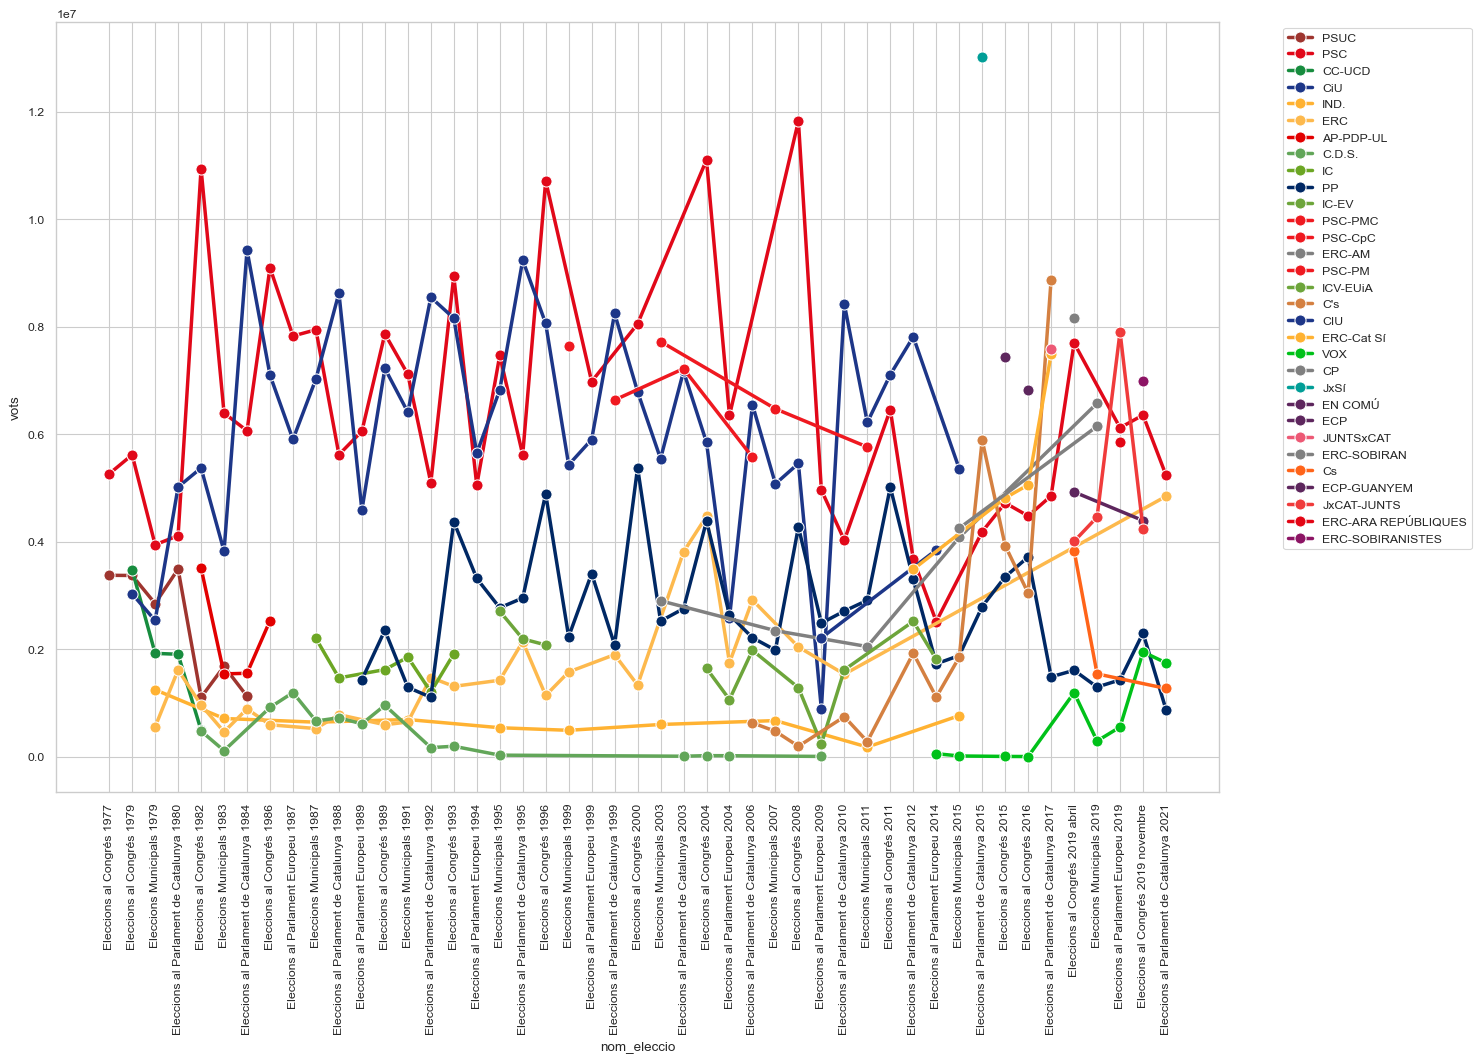

In [ ]:
important_candidatures_info = candidatures_info[
    candidatures_info["num_votes"] > 5000000
]

# Filter the original dataset with the important candidatures
important_candidatures_df = df[
    df["party_abbr"].isin(important_candidatures_info.party_abbr)
]

# Replace NaN values in the 'party_color' column with a default color, e.g., 'grey'
important_candidatures_df["party_color"].fillna("grey", inplace=True)

# Use year, month and day columns to create a column date
important_candidatures_df["date"] = pd.to_datetime(
    important_candidatures_df[["year", "month", "day"]]
)


def plot_candidatures_evolution(
    df: pd.DataFrame, x="nom_eleccio", y="vots", hue="party_abbr"
) -> None:
    """
    Plots the temporal evolution of the number of votes for candidatures
    contained within the provided DataFrame. It creates a color palette
    based on candidature colors indicated in the DataFrame and uses it to
    color the line plot for each candidature.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the election data. It is expected
      to have at least 'nom_eleccio' (election name), 'date' (election date),
      'party_abbr' (candidature abbreviations), 'vots' (votes), and
      'party_color' (colors associated with each candidature) columns.

    Returns:
    - None: This function directly plots the temporal evolution of votes for
      candidatures and does not return any value.
    """

    # Assuming 'df' is already sorted as needed and contains necessary columns

    # Create a color palette dictionary
    color_palette = {
        sigles: color
        for sigles, color in zip(
            df["party_abbr"],
            df["party_color"],
        )
    }

    # Plot temporal evolution of the number of votes for the candidatures
    sns.set_style("whitegrid")
    sns.set_context("paper")

    plt.figure(figsize=(15, 10))
    sns.lineplot(
        x=x,
        y=y,
        hue=hue,
        data=df,
        palette=color_palette,
        markers=True,
        dashes=False,
        linewidth=2.5,
        marker="o",
        markersize=8,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.xticks(rotation=90)

    plt.show()


def plot_candidature_evolution(df: pd.DataFrame) -> None:
    """
    Aggregates votes per candidature for each election within the provided DataFrame,
    sorts the aggregated data by date, creates a color palette based on candidature colors,
    and plots the temporal evolution of votes for important candidatures.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing election data. Expected to have at least the following columns:
      'nom_eleccio' (election name), 'date' (election date), 'party_abbr' (candidature abbreviations),
      'vots' (votes), and 'party_color' (colors associated with each candidature).

    Returns:
    - None: This function does not return a value but directly plots the aggregated election data.
    """
    # Aggregate votes per candidature for each election
    aggregated_df = (
        df.groupby(["nom_eleccio", "date", "party_abbr"])
        .agg({"vots": "sum", "party_color": "first"})
        .reset_index()
    )

    # Sort the DataFrame by 'date'
    sorted_df = aggregated_df.sort_values(by=["date"])

    plot_candidatures_evolution(sorted_df)


plot_candidature_evolution(important_candidatures_df)

In [ ]:

def find_duplicate_candidatures(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identifies candidatures that appear more than once in the same election within the provided DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame to check for duplicates. It must contain 'nom_eleccio' (election name),
      'date' (election date), and 'party_abbr' (party abbreviations) columns.

    Returns:
    - pd.DataFrame: A DataFrame containing the rows where candidatures appear more than once in the same
      election, based on 'nom_eleccio', 'date', and 'party_abbr' columns.
    """
    
    # Find duplicates based on 'nom_eleccio', 'date', and 'party_abbr' columns
    duplicate_df = df[
        df.duplicated(subset=["nom_eleccio", "date", "party_abbr"], keep=False)
    ]
    
    return duplicate_df

# To use this function, you would call it like this:
duplicate_candidatures = find_duplicate_candidatures(important_candidatures_df)
duplicate_candidatures

,index_autonumeric,id_eleccio,nom_eleccio,id_nivell_territorial,nom_nivell_territorial,territori_codi,territori_nom,seccio,vots,escons,...,type,year,sequential,month,day,party_code,party_name,party_abbr,party_color,date
1,2,A19801,Eleccions al Parlament de Catalunya 1980,CA,Catalunya,9,Catalunya,0.0,507753,25.0,...,A,1980,1,3,20,4,Partit Socialista Unificat de Catalunya,PSUC,#9E352F,1980-03-20
2,3,A19801,Eleccions al Parlament de Catalunya 1980,CA,Catalunya,9,Catalunya,0.0,606717,33.0,...,A,1980,1,3,20,6,Partit dels Socialistes de Catalunya (PSC-PSOE),PSC,#DD2809,1980-03-20
4,5,A19801,Eleccions al Parlament de Catalunya 1980,CA,Catalunya,9,Catalunya,0.0,240871,14.0,...,A,1980,1,3,20,10,Esquerra Republicana de Catalunya,ERC,#FFB232,1980-03-20
6,7,A19801,Eleccions al Parlament de Catalunya 1980,CA,Catalunya,9,Catalunya,0.0,752943,43.0,...,A,1980,1,3,20,12,Convergència i Unió,CiU,#1D3688,1980-03-20
10,11,A19801,Eleccions al Parlament de Catalunya 1980,CA,Catalunya,9,Catalunya,0.0,286922,18.0,...,A,1980,1,3,20,21,Centristes de Catalunya-UCD,CC-UCD,#178C3E,1980-03-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19750944,12191227,M20191,Eleccions Municipals 2019,CA,Catalunya,9,Catalunya,NaN,192518,240.0,...,M,2019,1,5,26,301,CIUTADANS-PARTIDO DE LA CIUDADANIA,Cs,grey,2019-05-26
19750946,12191834,M20191,Eleccions Municipals 2019,CO,Comarca,17,Garraf,NaN,6126,10.0,...,M,2019,1,5,26,301,CIUTADANS-PARTIDO DE LA CIUDADANIA,Cs,grey,2019-05-26
19750948,12293306,M20191,Eleccions Municipals 2019,MU,Municipi,8148,Olivella,NaN,93,1.0,...,M,2019,1,5,26,301,CIUTADANS-PARTIDO DE LA CIUDADANIA,Cs,grey,2019-05-26
19750950,12296114,M20191,Eleccions Municipals 2019,PR,Provincia,8,Barcelona,NaN,142676,161.0,...,M,2019,1,5,26,301,CIUTADANS-PARTIDO DE LA CIUDADANIA,Cs,#D48041,2019-05-26


In [ ]:
df[df["escons"].isnull()].value_counts("type")

type
G    347688
E    267808
M     93994
Name: count, dtype: int64

In [ ]:
escons_int = pd.to_numeric(df_original["escons"], errors="coerce", downcast="integer")


In [ ]:
df_escons_null = df[df["escons"].isnull()]

In [ ]:
df_escons_null.value_counts("nom_nivell_territorial")

nom_nivell_territorial
Mesa                   607834
Secció                  70673
Districte Municipal     17142
Municipi                13045
Comarca                   596
Vegueria                  130
Província                  55
Comunitat Autònoma         15
Name: count, dtype: int64

In [ ]:
df_escons_null.value_counts("id_nivell_territorial")

id_nivell_territorial
ME    607834
SE     70673
DM     17142
MU     13045
CO       596
VE       130
PR        55
CA        15
Name: count, dtype: int64

In [ ]:
df_filtered = df[df["id_nivell_territorial"].isin(["CA", "PR", "MU"])]
df_escons_null_filtered = df_filtered[df_filtered["escons"].isnull()]
df_escons_null_filtered["type"].value_counts()

type
G    13115
Name: count, dtype: int64

We observed that some values of `escons` were `NaN`. That was really strange and we investigate it. We arrived at the conclusion that polling stations (`Mesa`), electoral sections (`Secció`), electoral districts (`Districte Municipal`), counties (`Comarca`) and vegueries (`Vegueria`) doesn't need to have seats assigned as there aren't territorial units that give seats.

But there are other regional units like autonomous comunities (`CA`), provinces (`Província`) and municipalities (`Municipi`) give seats but also have null values of seats. After analyzing the data, we realized that there isn't seats data on the Spanish general elections (`G`).

## Create new columnns with vote percentage

We want to get the percentage of votes of each candidature, so we'll create a new column called `votes_percentage`:

In [ ]:
df_participation = pd.read_pickle('../../data/processed/catalan-elections-clean-participation.pkl')
df_participation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678882 entries, 0 to 678881
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   index_autonumeric       678882 non-null  Int64         
 1   id_eleccio              678882 non-null  string        
 2   nom_eleccio             678882 non-null  object        
 3   id_nivell_territorial   678882 non-null  string        
 4   nom_nivell_territorial  678882 non-null  string        
 5   territori_codi          678882 non-null  string        
 6   territori_nom           678882 non-null  string        
 7   districte               624021 non-null  Int64         
 8   seccio                  633605 non-null  Int64         
 9   cens_electoral          678882 non-null  Int64         
 10  votants                 678882 non-null  int32         
 11  vots_nuls               678882 non-null  Int64         
 12  vots_blancs             678882

In [ ]:
df_clean = pd.read_pickle('../../data/processed/catalan-elections-clean-data.pkl')

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12339340 entries, 0 to 12339339
Data columns (total 24 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   index_autonumeric       Int64         
 1   id_eleccio              string        
 2   nom_eleccio             object        
 3   id_nivell_territorial   string        
 4   nom_nivell_territorial  string        
 5   territori_codi          string        
 6   territori_nom           string        
 7   seccio                  Int64         
 8   vots                    int32         
 9   escons                  Int64         
 10  districte               Int64         
 11  mesa                    string        
 12  party_code              int32         
 13  party_name              object        
 14  party_abbr              object        
 15  party_color             string        
 16  clean_party_name        object        
 17  clean_party_abbr        object        
 18  

In [ ]:
df_participation = df_participation[
    df_participation["id_nivell_territorial"].isin(["SE"])
]

We are only interested on censal sections, so we'll filter out the other types of sections:

In [ ]:
df_censal_sections = df_clean[df_clean["id_nivell_territorial"] == "SE"]

In [ ]:
df_censal_sections.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4273365 entries, 117538 to 12338913
Data columns (total 24 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   index_autonumeric       Int64         
 1   id_eleccio              string        
 2   nom_eleccio             object        
 3   id_nivell_territorial   string        
 4   nom_nivell_territorial  string        
 5   territori_codi          string        
 6   territori_nom           string        
 7   seccio                  Int64         
 8   vots                    int32         
 9   escons                  Int64         
 10  districte               Int64         
 11  mesa                    string        
 12  party_code              int32         
 13  party_name              object        
 14  party_abbr              object        
 15  party_color             string        
 16  clean_party_name        object        
 17  clean_party_abbr        object        
 18  t

In [ ]:
# get the names of columns that only  of df_censal_sections
df_censal_sections[["year", "month", "day", "territori_codi", "seccio", "districte", "mesa", "party_code"]][
    df_censal_sections[["year", "month", "day", "territori_codi", "seccio", "districte", "mesa", "party_code"]].duplicated()
]

,year,month,day,territori_codi,seccio,districte,mesa,party_code
11040778,1979,4,3,08019,1,1,,3000000
11040785,1979,4,3,08019,1,1,,3000000
11040793,1979,4,3,08019,2,1,,3000000
11040800,1979,4,3,08019,2,1,,3000000
11040808,1979,4,3,08019,3,1,,3000000
...,...,...,...,...,...,...,...,...
12338898,2019,5,26,43907,2,1,<NA>,301
12338902,2019,5,26,43907,3,1,<NA>,86
12338904,2019,5,26,43907,3,1,<NA>,301
12338908,2019,5,26,43907,4,1,<NA>,86


In [ ]:
# del (
#     candidatures,
#     candidatures_abbr,
#     candidatures_code,
#     candidatures_info,
#     candidatures_num_elections,
#     candidatures_seats,
#     candidatures_votes,
#     candidatures_with_agrupacio_codi_info,
#     candidatures_without_agrupacio_codi_info,
#     candidatures_referenced,
#     df_escons_null,
#     df_escons_null_filtered,
#     df_filtered,
#     df_grouped,
#     df_original,
#     df_elections_days,
#     df,
#     important_candidatures_df,
#     important_candidatures_info,
#     escons_int,
#     duplicate_candidatures,
# )

In [ ]:
print(df_censal_sections.shape)

print(df_participation.shape)

(4273365, 24)
(227502, 23)


In [ ]:
df_participation["territori_codi"] = (
    df_participation["territori_codi"].astype("string").str.lstrip("0")
)
df_censal_sections["territori_codi"] = (
    df_censal_sections["territori_codi"].astype("string").str.lstrip("0")
)

df_censal_sections = df_censal_sections[
    [
        "index_autonumeric",
        "id_eleccio",
        "territori_codi",
        "territori_nom",
        "seccio",
        "vots",
        "districte",
        "party_code",
        "party_name",
        "party_abbr",
        "party_color",
        "clean_party_name",
        "clean_party_abbr",
        "type",
        "year",
        "round",
    ]
].merge(
    df_participation[
        [
            "id_eleccio",
            "territori_codi",
            "districte",
            "seccio",
            "cens_electoral",
            "vots_valids",
            "vots_blancs",
            "vots_nuls",
            "votants",
        ]
    ],
    on=["id_eleccio", "territori_codi", "districte", "seccio"],
    how="left",
)

df_censal_sections.head()

C:\Users\guill\AppData\Local\Temp\ipykernel_24884\3267459093.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_censal_sections["territori_codi"] = (


,index_autonumeric,id_eleccio,territori_codi,territori_nom,seccio,vots,districte,party_code,party_name,party_abbr,...,clean_party_name,clean_party_abbr,type,year,round,cens_electoral,vots_valids,vots_blancs,vots_nuls,votants
0,117342,A19801,8001,Abrera,1,2,1,1,Conservadors de Catalunya,C.i.C.,...,conservadors de catalunya,c.i.c.,A,1980,1,2302,1619,10,8,1627.0
1,117343,A19801,8001,Abrera,1,389,1,4,Partit Socialista Unificat de Catalunya,PSUC,...,partit socialista unificat de catalunya,psuc,A,1980,1,2302,1619,10,8,1627.0
2,117344,A19801,8001,Abrera,1,407,1,6,Partit dels Socialistes de Catalunya (PSC-PSOE),PSC,...,partit dels socialistes de catalunya pscpsoe,psc,A,1980,1,2302,1619,10,8,1627.0
3,117345,A19801,8001,Abrera,1,7,1,8,Fuerza Nueva,FN,...,fuerza nueva,fn,A,1980,1,2302,1619,10,8,1627.0
4,117346,A19801,8001,Abrera,1,81,1,10,Esquerra Republicana de Catalunya,ERC,...,esquerra republicana de catalunya,erc,A,1980,1,2302,1619,10,8,1627.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4273360,12356193,M20191,43907,"Canonja, la",4,53,1,2019839,ESQUERRA REPUBLICANA DE CATALUNYA-ACORD MUNICIPAL,ERC-AM,...,esquerra republicana de catalunyaacord municipal,ercam,M,2019,1,1148,687,3,2,689.0
4273361,12356194,M20191,43907,"Canonja, la",4,63,1,301,CIUTADANS-PARTIDO DE LA CIUDADANIA,Cs,...,ciutadanspartido de la ciudadania,cs,M,2019,1,1148,687,3,2,689.0
4273362,12356195,M20191,43907,"Canonja, la",4,435,1,2019838,PARTIT DELS SOCIALISTES DE CATALUNYA - CANDIDA...,CP,...,partit dels socialistes de catalunya candidat...,cp,M,2019,1,1148,687,3,2,689.0
4273363,12356196,M20191,43907,"Canonja, la",4,70,1,20191039,CANDIDATURA D'UNITAT POPULAR-ALTERNATIVA MU...,CUP-AMUNT,...,candidatura d'unitat popularalternativa mun...,cupamunt,M,2019,1,1148,687,3,2,689.0


In [ ]:
# show those sections that are in df_censal_sections but not in df_partition
df_censal_sections[
    ~df_censal_sections[["id_eleccio", "territori_codi", "districte", "seccio"]]
    .apply(tuple, 1)
    .isin(
        df_participation[["id_eleccio", "territori_codi", "districte", "seccio"]].apply(
            tuple, 1
        )
    )
][
    [
        "id_eleccio",
        "territori_codi",
        "territori_nom",
        "districte",
        "seccio", 
        "cens_electoral",
        "vots_valids",
        "vots_blancs",
        "vots_nuls",
        "votants",
    ]
]

,id_eleccio,territori_codi,territori_nom,districte,seccio,cens_electoral,vots_valids,vots_blancs,vots_nuls,votants
3604,A19801,8019,Barcelona,10,31,<NA>,<NA>,<NA>,<NA>,NaN
3605,A19801,8019,Barcelona,10,31,<NA>,<NA>,<NA>,<NA>,NaN
3606,A19801,8019,Barcelona,10,31,<NA>,<NA>,<NA>,<NA>,NaN
3607,A19801,8019,Barcelona,10,31,<NA>,<NA>,<NA>,<NA>,NaN
3608,A19801,8019,Barcelona,10,31,<NA>,<NA>,<NA>,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...
43739,A19801,8298,Vic,3,4,<NA>,<NA>,<NA>,<NA>,NaN
43740,A19801,8298,Vic,3,4,<NA>,<NA>,<NA>,<NA>,NaN
43741,A19801,8298,Vic,3,4,<NA>,<NA>,<NA>,<NA>,NaN
43742,A19801,8298,Vic,3,4,<NA>,<NA>,<NA>,<NA>,NaN


Some sections are missing from the participation dataset. There's no way we can recover the voters infomation of these sections, so we'll remove those rows from the dataset.

In [ ]:
# remove rows with missing values in vots_valids
df_censal_sections = df_censal_sections.dropna(subset=["vots_valids"])

For each party, calculate the percentage of votes in each section, we'll call the new column `votes_percentage`:

In [ ]:
df_censal_sections["votes_percentage"] = (
    100 * df_censal_sections["vots"] / df_censal_sections["vots_valids"]
)

df_censal_sections.head()

,index_autonumeric,id_eleccio,territori_codi,territori_nom,seccio,vots,districte,party_code,party_name,party_abbr,...,clean_party_abbr,type,year,round,cens_electoral,vots_valids,vots_blancs,vots_nuls,votants,votes_percentage
0,117342,A19801,8001,Abrera,1,2,1,1,Conservadors de Catalunya,C.i.C.,...,c.i.c.,A,1980,1,2302,1619,10,8,1627.0,0.123533
1,117343,A19801,8001,Abrera,1,389,1,4,Partit Socialista Unificat de Catalunya,PSUC,...,psuc,A,1980,1,2302,1619,10,8,1627.0,24.027177
2,117344,A19801,8001,Abrera,1,407,1,6,Partit dels Socialistes de Catalunya (PSC-PSOE),PSC,...,psc,A,1980,1,2302,1619,10,8,1627.0,25.138975
3,117345,A19801,8001,Abrera,1,7,1,8,Fuerza Nueva,FN,...,fn,A,1980,1,2302,1619,10,8,1627.0,0.432366
4,117346,A19801,8001,Abrera,1,81,1,10,Esquerra Republicana de Catalunya,ERC,...,erc,A,1980,1,2302,1619,10,8,1627.0,5.003088


In [ ]:
sorted(df_censal_sections[
    (df_censal_sections["id_eleccio"] == "A19801")
    & (df_censal_sections["territori_codi"] == "8019")
    & (df_censal_sections["districte"] == 10)
    # & (df_censal_sections["seccio"] == 1)
]["seccio"].unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97]

In [ ]:
sorted(df_participation[
    (df_participation["id_eleccio"] == "A19801")
    & (df_participation["territori_codi"] == "8019")
    & (df_participation["districte"] == 10)
    # & (df_participation["seccio"] == 1)
]["seccio"].unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97]